In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (Wav2Vec2Processor, Wav2Vec2ForSequenceClassification,
                          Trainer, TrainingArguments, DataCollatorWithPadding)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define dataset directory
DATASET_PATH = "../input/urbansound8k/UrbanSound8K.csv"  # Adjust for Kaggle
AUDIO_PATH = "../input/urbansound8k/"

# Load metadata
metadata = pd.read_csv(DATASET_PATH)

# Create file paths
file_paths = [os.path.join(AUDIO_PATH, "fold{}".format(row['fold']), row["slice_file_name"]) for _, row in metadata.iterrows()]
labels = metadata["classID"].values

# Train-test split
train_paths, test_paths, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Load pre-trained processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# Function to preprocess audio
def preprocess_audio(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        inputs = processor(
            audio,
            sampling_rate=16000,
            return_tensors="pt",
            padding="max_length",
            max_length=16000 * 5,
            truncation=True
        )
        return inputs.input_values.squeeze(0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Custom Dataset class
class UrbanSoundDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.valid_data = [(fp, lbl) for fp, lbl in zip(file_paths, labels) if os.path.exists(fp)]

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        file_path, label = self.valid_data[idx]
        input_values = preprocess_audio(file_path)
        if input_values is None:
            input_values = torch.zeros((16000,))
        return {"input_values": input_values, "labels": torch.tensor(label, dtype=torch.long)}

# Create datasets
train_dataset = UrbanSoundDataset(train_paths, y_train)
test_dataset = UrbanSoundDataset(test_paths, y_test)

# Load model
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model.gradient_checkpointing_enable()

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=40,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=processor.feature_extractor)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print("Evaluation Results:", metrics)

# Save model
SAVE_PATH = "./wav2vec2_model"
model.save_pretrained(SAVE_PATH)
processor.save_pretrained(SAVE_PATH)

# Predictions
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids
preds = np.argmax(logits, axis=-1)
accuracy = np.mean(preds == labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.814900,0.814130,0.775043
2,0.799400,0.561218,0.838580
3,0.563700,0.564829,0.859187
4,0.377600,0.477941,0.896966
5,0.846300,0.504385,0.904408
6,0.503800,0.442338,0.921580
7,0.318200,0.442158,0.923869
8,0.173000,0.436139,0.924442
9,0.273000,0.456965,0.931883
10,0.178400,0.462974,0.934173


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 127466432 vs 127466324

In [10]:
training_args = TrainingArguments(
    output_dir="/kaggle/outputs/my_model/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=40,  # Increase the number of epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000200,0.426970,0.947911
2,0.000900,0.552015,0.937607
3,0.015200,0.445706,0.947338
4,0.000100,0.445942,0.944476
5,0.022300,0.505050,0.931883
6,0.195500,0.348896,0.955352
7,0.048300,0.573899,0.934173
8,0.000200,0.408206,0.950773
9,0.073700,0.486753,0.946766
10,0.000200,0.474116,0.943331


TrainOutput(global_step=34960, training_loss=0.034602499126164525, metrics={'train_runtime': 19622.3552, 'train_samples_per_second': 14.239, 'train_steps_per_second': 1.782, 'total_flos': 1.2683125532352012e+19, 'train_loss': 0.034602499126164525, 'epoch': 40.0})

In [ ]:
training_args = TrainingArguments(
    output_dir="/kaggle/outputs/my_model/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=60,  # Increase the number of epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train(resume_from_checkpoint=True)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weight

Epoch,Training Loss,Validation Loss


In [6]:
!df -h


Filesystem                                                            Size  Used Avail Use% Mounted on
overlay                                                               7.9T  6.1T  1.9T  77% /
tmpfs                                                                  64M     0   64M   0% /dev
shm                                                                    14G  4.0K   14G   1% /dev/shm
/dev/loop1                                                             20G   20G     0 100% /kaggle/lib
192.168.14.2:/data/kagglesdsdata/datasets/500970/928025/d8rd3d0uc0bj   30T   22T  8.6T  72% /kaggle/input/urbansound8k
/dev/sda1                                                             122G   25G   97G  21% /opt/bin
/dev/mapper/snap                                                      7.9T  6.1T  1.9T  77% /etc/hosts
tmpfs                                                                  16G     0   16G   0% /proc/acpi
tmpfs                                                                  16G 

In [7]:
trainer.save_model("/kaggle/outputs/my_model/")


In [13]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions from the trained model
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits = predictions.predictions
labels = predictions.label_ids

# Convert logits to predicted class labels
preds = np.argmax(logits, axis=-1)


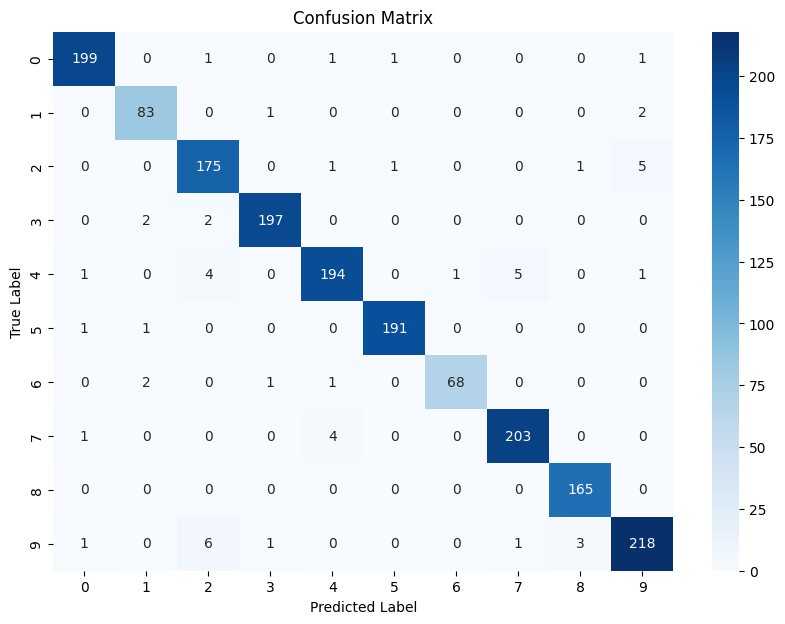

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [15]:
# Generate a classification report
report = classification_report(labels, preds, target_names=[f"Class {i}" for i in range(10)])

print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       203
     Class 1       0.94      0.97      0.95        86
     Class 2       0.93      0.96      0.94       183
     Class 3       0.98      0.98      0.98       201
     Class 4       0.97      0.94      0.95       206
     Class 5       0.99      0.99      0.99       193
     Class 6       0.99      0.94      0.96        72
     Class 7       0.97      0.98      0.97       208
     Class 8       0.98      1.00      0.99       165
     Class 9       0.96      0.95      0.95       230

    accuracy                           0.97      1747
   macro avg       0.97      0.97      0.97      1747
weighted avg       0.97      0.97      0.97      1747



In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average="weighted")
recall = recall_score(labels, preds, average="weighted")
f1 = f1_score(labels, preds, average="weighted")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 96.91%
Precision: 0.9692
Recall: 0.9691
F1-score: 0.9691
